In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torch 
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
from timm.optim import create_optimizer_v2, optimizer_kwargs
from timm import utils
from timm.loss import JsdCrossEntropy, SoftTargetCrossEntropy, BinaryCrossEntropy, LabelSmoothingCrossEntropy
from timm import scheduler
from torch.optim import Adam
from sklearn.model_selection import train_test_split

import glob
from tqdm.notebook import tqdm
import argparse
import logging
import os
import time
from collections import OrderedDict
from contextlib import suppress
from datetime import datetime
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torchvision.utils
import yaml
from torch.nn.parallel import DistributedDataParallel as NativeDDP
from PIL import Image
import torchvision

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('The model will be running on', device, 'device')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


The model will be running on cuda:0 device


In [2]:
class BreastCancerDataset(Dataset):
    def __init__(self, data_path_file, train=True):
        super(Dataset, self).__init__()
        self.data = pd.read_csv(data_path_file,index_col=0)
        self.global_path = "/kaggle/input/meta-data/Data_image/"
        self.train = train
        if train:
            # Define the training data augmentation pipeline
            self.transform = transforms.Compose([
                transforms.Grayscale(num_output_channels=3),
                transforms.Resize(size=(224,224)),
#                 transforms.RandomResizedCrop(size=(384,384), scale=(0.8, 1), ratio=(0.45, 0.55)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(5),
                transforms.ColorJitter(brightness=0.1, contrast=0.1),
                transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.9, 1.1)),
                transforms.ToTensor(),

                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
            ])
        else:
            # Define the validation and testing pipeline
            self.transform = transforms.Compose([
                transforms.Grayscale(num_output_channels=3),
                transforms.Resize(size=(224,224)),
#                 transforms.CenterCrop(size=224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
            ])

    def __len__(self):
        return len(self.data)
    def zero_mean_normalize_image(self, image):
        mean = np.mean(image)
        std = np.std(image)
        normalized_image = (image - mean) / std
        return normalized_image

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        label = row['status']
        dic = {0: 'Bengin', 1:'Mag' }
        if self.train:
            path_global = f'/kaggle/input/ddsm-dataset/DDSM Dataset/'
        else:
            path_global = f'/kaggle/input/ddsm-dataset/DDSM Dataset/'
            
#         name = f"{os.path.basename(row['Image']).replace('.png', '')}_{row.roatation_120}_{row.roatation_240}_{row.clahe}.png"
        name = row.Image.replace('\\', '/')
        img_path = os.path.join(path_global, name)
        
#         image = cv2.imread(img_path)
#         if self.train == False:
#             image =getRecoverScene(image, refine=True)
        image = Image.open(img_path)
#         image = Image.fromarray(image)
        labels = torch.tensor(label)

        if self.transform:
            image = self.transform(image)

        return image, labels, name
# Như vậy, bạn chỉ cần chuyển đổi ảnh xám đã xử lý thành đối tượng hình ảnh (Image) và sau đó áp dụng các biến đổi còn lại trong pipeline của bạn.

In [3]:
path_train = '/kaggle/input/data-paper/train.csv'
path_val = '/kaggle/input/data-paper/test.csv'


In [4]:
def check_exits(path, train=True):
    data = pd.read_csv(path)
    global_path =  "/kaggle/input/meta-data/Data_image/"
    for idx in tqdm(data.index):
        row = data.iloc[idx]
        
        label = row['status']
        dic = {0: 'Bengin', 1:'Mag' }
        if train:
            path_global = f'/kaggle/input/ddsm-dataset/DDSM Dataset/'
        else:
            path_global = f'/kaggle/input/ddsm-dataset/DDSM Dataset/'
#         if label == 1:
            
#         name = f"{os.path.basename(row['Image']).replace('.png', '')}_{row.roatation_120}_{row.roatation_240}_{row.clahe}.png"
        name = row.Image.replace('\\', '/')
        img_path = os.path.join(path_global, name)
        if os.path.exists(img_path) == False:
            print(img_path)
#         if os.path.exists(img_path_mask) == False:
#             print(img_path_mask)

In [5]:
check_exits(path_train)

  0%|          | 0/1093 [00:00<?, ?it/s]

In [6]:
check_exits(path_val, train=False)

  0%|          | 0/1095 [00:00<?, ?it/s]

In [7]:
# Đường dẫn đến tệp văn bản bạn muốn đọc
file_path = "/kaggle/input/data-clahe/description_True.txt"
print(os.path.basename(file_path))
# Mở tệp văn bản để đọc
with open(file_path, 'r') as file:
    # Duyệt qua từng dòng trong tệp và in ra
    for line in file:
        print(line.strip())  # strip() để loại bỏ ký tự xuống dòng (\n)

# Sau khi vòng lặp kết thúc, tệp sẽ tự đóng


description_True.txt
Name Dataset: CIBS-DDSM
Quantity Image: 7176
Image Size: (224, 224)
thred: 2
Normalization: 1
Detail: Normalization after
Apply haze removal: 1


In [8]:
# Đường dẫn đến tệp văn bản bạn muốn đọc
file_path = "/kaggle/input/data-clahe/description_False.txt"
print(os.path.basename(file_path))
# Mở tệp văn bản để đọc
with open(file_path, 'r') as file:
    # Duyệt qua từng dòng trong tệp và in ra
    for line in file:
        print(line.strip())  # strip() để loại bỏ ký tự xuống dòng (\n)

# Sau khi vòng lặp kết thúc, tệp sẽ tự đóng


description_False.txt
Name Dataset: CIBS-DDSM
Quantity Image: 2088
Image Size: (224, 224)
thred: 5
Normalization: 1
Detail: Normalization after
Apply haze removal: 1


In [9]:
def infor(path, name):
    data = pd.read_csv(path)
    print(name)
    print(data.status.value_counts())
#     print(data.Type.value_counts())

In [10]:
infor(path_train, 'train')

train
1    596
0    497
Name: status, dtype: int64


In [11]:
infor(path_val, 'val')

val
1    597
0    498
Name: status, dtype: int64


In [12]:
# Tính toán trọng số cho mỗi lớp để cân bằng dữ liệu
def compute_class_weights(labels):
    class_frequencies = torch.bincount(labels)
    total_samples = len(labels)
    class_weights = total_samples / (2.0 * class_frequencies)
    return class_weights

In [13]:
train_dataset = BreastCancerDataset(path_train,train=True)
val_dataset = BreastCancerDataset(path_val,train=False)
# test_dataset_DDSM = BreastCancerDataset(path_test_DDSM,train=False)

In [14]:
from torch.utils.data.sampler import WeightedRandomSampler
# Tạo DataLoader cho dữ liệu đã cân bằng
def create_balanced_dataloader(path_train, batch_size):
    dataframe = pd.read_csv(path_train)
    class_counts = dataframe.status.value_counts()
    class_weights = 1/class_counts
    sample_weights = [1/class_counts[i] for i in dataframe.status.values]
    train_dataset = BreastCancerDataset(path_train,train=True)
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_dataset), replacement=True)
    dataloader = DataLoader(train_dataset,batch_size=batch_size, sampler=sampler)

    return dataloader

In [15]:
# train_dataset = BreastCancerDataset(path_train,train=True)
val_dataset = BreastCancerDataset(path_val,train=False)
# test_dataset_DDSM = BreastCancerDataset(path_test_DDSM,train=False)
# train_dataset = BreastCancerDataset(path_train,train=True)
# val_dataset = BreastCancerDataset(path_val,train=False)

In [16]:
batch_size = 64
# train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
# val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=True)
# test_loader_DDSM = DataLoader(test_dataset_DDSM,batch_size=batch_size,shuffle=True)

train_loader = create_balanced_dataloader(path_train, batch_size)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=True)

In [17]:
train = pd.read_csv(path_train)
val = pd.read_csv(path_val)
# test = pd.read_csv(path_test_DDSM)

print(f"The number of image: {len(train) + len(val)}")

The number of image: 2188


In [18]:
def save_model(config, epochs, model, optimizer, criterion, pretrained="True"):
    """
    Function to save the trained model to disk.
    """
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, f"/kaggle/working/{config.model}_{epochs}.pth")
    print(f'Save model --> {config.model}_{epochs}.pth')

In [19]:
def apply_softmax(y_preds):
    softmax_preds = F.softmax(y_preds, dim=1)
    return softmax_preds

In [20]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, config, f1_scores, epochs, model, optimizer, criterion, pretrained="True"):

        score = f1_scores

        if self.best_score is None:
            self.best_score = score
            save_model(config, epochs, model, optimizer, criterion, pretrained="True")
        elif score <= self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            save_model(config, epochs, model, optimizer, criterion, pretrained="True")
            self.counter = 0

In [21]:
def validate(
        model,
        loader,
        loss_fn,
        config,
        device=torch.device('cuda'),
        amp_autocast=suppress,
        log_suffix='',
        data_name = "val"
):  

    model.eval()
    label_list = []
    label_pred_list = []
    last_idx = len(loader) - 1
    val_loss = .0
    val_acc = .0
    f1_scr = .0
    with torch.no_grad():
        for batch_idx, (inputs, target, name) in enumerate(loader):
#             label = target
            target = F.one_hot(target, config.num_classes)
            
            inputs = inputs.to(device, dtype=torch.float)
            target = target.to(device, dtype=torch.float )

            with amp_autocast():
                output = model(inputs)
                if isinstance(output, (tuple, list)):
                    output = output[0]
                

            loss = loss_fn(output, target)

            val_loss += loss.item()
            output = apply_softmax(output)

            predicted = torch.max(output, 1)[1].to(device)
            label = torch.max(target, 1)[1].to(device)
            label_list.append(label.cpu())
            label_pred_list.append(predicted.cpu())

    # Tính toán độ chính xác cho toàn bộ tập dữ liệu validation
    label_list = np.concatenate([labels.numpy() for labels in label_list])
    label_pred_list = np.concatenate([preds.numpy() for preds in label_pred_list])
    val_acc = np.sum(label_list == label_pred_list) / len(label_list)
#     print(label_list)
    # Tính toán F1 score
    f1_scr = f1_score(label_list, label_pred_list, average='weighted')

    metrics = {
        "data": data_name,
        "acc": val_acc,
        "loss": val_loss / len(loader),  # Chia cho số lượng batch để tính trung bình
        "f1": f1_scr
    }
#     print(metrics)
    return metrics

In [22]:
def train_one_epoch(
        epoch,
        model,
        loader,
        optimizer,
        loss_fn,
        device=torch.device('cuda'),
        lr_scheduler=None,
        saver=None,
        output_dir=None,
        amp_autocast=suppress,
        loss_scaler=None,
        model_ema=None,
        mixup_fn=None,
        config=None
):
    losses_m = utils.AverageMeter()
    model.train()
    '''
    scaler: là một phần của tích hợp đào tạo dựa trên tự động hỗ trợ (Automatic Mixed Precision - AMP) trong PyTorch. 
    AMP là một kỹ thuật giúp tăng tốc độ đào tạo và giảm bộ nhớ sử dụng bằng cách sử dụng kiểu dữ liệu có độ chính xác thấp (float16)
    cho tính toán gradient và tự động chuyển đổi về kiểu dữ liệu cao hơn (float32) khi cần thiết để tránh tràn số và
    giảm thiểu sai số tính toán.
    AMP trong PyTorch sử dụng phép chia tỷ lệ gradient (gradient scaling) để tránh tràn số.
    Khi thực hiện lan truyền ngược (backpropagation), gradient được tính toán dựa trên kiểu dữ liệu float16. 
    Trong quá trình cập nhật trọng số, torch.cuda.amp.GradScaler sẽ điều chỉnh gradient sao cho giá trị của gradient 
    không bị tràn số. Nếu gradient quá lớn, nó sẽ được scale về mức an toàn để tránh tràn số khi cập nhật trọng số.
    '''
    scaler = torch.cuda.amp.GradScaler(enabled=config.apex)
    dataset_size = 0
    running_loss = 0.0
    num_batches_per_epoch = len(loader)
    num_updates = epoch * num_batches_per_epoch
    label_list = []
    label_pred_list = []
    last_idx = len(loader) - 1
    val_acc = .0     
    for batch_idx, (inputs, target, name) in tqdm(enumerate(loader), total=num_batches_per_epoch):         
        target = F.one_hot(target, config.num_classes)

        inputs = inputs.to(device, dtype=torch.float)
        target = target.to(device, dtype=torch.float )
        with torch.cuda.amp.autocast(enabled=config.apex):
            output = model(inputs)
        loss = loss_fn(output, target)
        
        # đặt tất cả gradient của các tham số về 0, 
        optimizer.zero_grad()
        # Cập nhật giá trị, lưu trữ hàm loss lại
        losses_m.update(loss.item(), inputs.size(0))
        
        
        
        # Thực hiện propagation
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        "Validation"
        
        output = apply_softmax(output)
                
        predicted = torch.max(output, 1)[1].to(device)
        label = torch.max(target, 1)[1].to(device)
#         print(predicted)
        label_list.append(label.cpu())
        label_pred_list.append(predicted.cpu())
        
        if model_ema is not None:
            model_ema.update(model)
        '''
        torch.cuda.synchronize() là một hàm trong PyTorch được sử dụng để đồng bộ hóa việc thực hiện các phép tính trên GPU. Khi ta thực hiện các phép tính trên GPU, các lệnh được gửi tới GPU để thực hiện là bất đồng bộ, điều này có nghĩa là Python sẽ tiếp tục thực hiện các lệnh tiếp theo mà không chờ GPU hoàn thành phép tính. Điều này tạo ra một chút "trễ" (latency) giữa việc gửi các lệnh tính toán đến GPU và thực tế thực hiện các phép tính trên GPU.
        '''
        torch.cuda.synchronize()
        
        num_updates += 1
        '''
        : lr_scheduler là một đối tượng hoặc lớp chịu trách nhiệm điều chỉnh tốc độ học (learning rate) của bộ tối ưu hóa trong quá trình huấn luyện. Tốc độ học quyết định tốc độ mà các trọng số của mô hình được cập nhật trong quá trình huấn luyện.
        '''
        if lr_scheduler is not None:
            lr_scheduler.step_update(num_updates=num_updates, metric=losses_m.avg)
        if hasattr(optimizer, 'sync_lookahead'):
            optimizer.sync_lookahead()
    # Tính toán độ chính xác cho toàn bộ tập dữ liệu validation
    label_list = np.concatenate([labels.numpy() for labels in label_list])
    label_pred_list = np.concatenate([preds.numpy() for preds in label_pred_list])
    val_acc = np.sum(label_list == label_pred_list) / len(label_list)
    f1_scr = f1_score(label_list, label_pred_list, average='weighted')
    metrics = {
        "data": "train",
        "acc": val_acc,
        "loss": losses_m.avg,  # Chia cho số lượng batch để tính trung bình
        "f1": f1_scr
    }
    return metrics

In [23]:
class Parameter_model:
    def __init__(self):
        self.channels_last = None
        self.pretrained = True
        self.in_chans = 3
        self.num_classes = 2
        self.drop = 0.5
        self.drop_path = 0.2
        self.gp = 'avg'
        self.num_epochs = 100

        self.lr = 0.000001
        self.grad_checkpointing = True
        self.channels_last = True
        self.model = "efficientnet_b0"
        self.smoothing = 0.1
        self.min_lr = 5e-5
        self.warmup_epochs = 4
        self.warmup_lr =  3e-5
        self.eval_metric = 'loss'
        self.apex = True
        self.gem =True
        self.check_point = None
        self.loss = 'fl'
        self.alpha = 0.25
        self.gamma = 2
        self.reduction = 'mean'
        self.loss = 'fl'
        self.gem = False
        self.path_checkpoint  = None

In [24]:
class focal_loss(nn.Module):
    def __init__(self, alpha: float = 0.25, gamma: float = 2, reduction: str = "none"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs: torch.Tensor, targets: torch.Tensor):
        """
        Original implementation from https://github.com/facebookresearch/fvcore/blob/master/fvcore/nn/focal_loss.py .
        Loss used in RetinaNet for dense detection: https://arxiv.org/abs/1708.02002.

        Args:
            inputs: A float tensor of arbitrary shape.
                    The predictions for each example.
            targets: A float tensor with the same shape as inputs. Stores the binary
                    classification label for each element in inputs
                    (0 for the negative class and 1 for the positive class).
            alpha: (optional) Weighting factor in range (0,1) to balance
                    positive vs negative examples or -1 for ignore. Default = 0.25
            gamma: Exponent of the modulating factor (1 - p_t) to
                   balance easy vs hard examples.
            reduction: 'none' | 'mean' | 'sum'
                     'none': No reduction will be applied to the output.
                     'mean': The output will be averaged.
                     'sum': The output will be summed.
        Returns:
            Loss tensor with the reduction option applied.
        """

#         if not torch.jit.is_scripting() and not torch.jit.is_tracing():
#             _log_api_usage_once(sigmoid_focal_loss)
        p = torch.sigmoid(inputs)
        ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
        p_t = p * targets + (1 - p) * (1 - targets)
        loss = ce_loss * ((1 - p_t) ** self.gamma)

        if self.alpha >= 0:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            loss = alpha_t * loss

        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()

        return loss

In [25]:
# Focal Loss


In [26]:
class mode_gem(nn.Module):    
    def __init__(self, features, pool, in_features):
        super(mode_gem, self).__init__()
        self.features = nn.Sequential(*features)
        self.fc = nn.Linear(in_features, 2)
        self.pool = pool
    
    def forward(self, x):
        o = self.features(x)
        o = self.pool(o).squeeze(-1).squeeze(-1)
        o = self.fc(o)
        return o
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'
def create_model_gem(config):
    models_b4 = timm.create_model(
        config.model,
        pretrained=config.pretrained,
        in_chans=config.in_chans,
        num_classes=config.num_classes,
        drop_rate=config.drop,
        drop_path_rate=config.drop_path,
        global_pool=config.gp
    )
    if 'vit' in config.model:
        return models_b4
    in_features  = None
    if "convnet" in config.model or "vit" in config.model: 
        in_features  = models_b4.head.in_features    # cho convnet 
    else :
        in_features  = models_b4.classifier.in_features # cho eff
    features = list(models_b4.children())[:-2]
    pool = GeM()
    model_pool = mode_gem(features, pool, in_features)
    return model_pool

In [27]:
info_epoch = pd.DataFrame(columns=["epoch", "train_loss", "train_acc",  "f1-train", "val_acc","val_loss", "f1-val"])

In [28]:
def train (config):
    in_chans = 3 # số kênh đầu vào
    print(f"############### Mode {config.model}  ###############")
    print(f'Gem : {config.gem }')
    if config.gem:
        model = create_model_gem(config)
    else:
        model = timm.create_model(
            config.model,
            pretrained=config.pretrained,
#             in_chans=config.in_chans,
            num_classes=config.num_classes,
            drop_rate=config.drop,
            drop_path_rate=config.drop_path,
#             act_layer = nn.GELU
#             global_pool=config.gp
        )

    
    model.to(device=device)

    optimizer = create_optimizer_v2(
        model,
        opt = 'AdamW',
        lr = config.lr,
        weight_decay=0.05,
        eps=1e-08
    )
     # setup automatic mixed-precision (AMP) loss scaling and op casting
    amp_autocast = suppress  # do nothing
    loss_scaler = None
    amp_dtype = torch.float16
    amp_autocast = partial(torch.autocast, device_type=device.type, dtype=amp_dtype)

    # setup exponential moving average of model weights
    ema_model = utils.ModelEmaV2(model, decay=0.98)
    # Setup loss
    train_loss_fn = None
    if config.loss =='fl':
        print("Apply Focal Loss")
        train_loss_fn = focal_loss(config.alpha, config.gamma, config.reduction).to(device=device)
    else:
        train_loss_fn = LabelSmoothingCrossEntropy(smoothing=config.smoothing).to(device=device)
    validate_loss_fn = nn.CrossEntropyLoss().to(device=device)
    
    # setup learning rate schedule and starting epoch
    updates_per_epoch = len(train_loader)
    num_epoch_repeat = config.num_epochs/2 
    num_epochs = config.num_epochs+10
    lr_scheduler = timm.scheduler.CosineLRScheduler(
        optimizer,
        t_initial=config.num_epochs+10,
        cycle_decay=0.5,
        lr_min=1e-6,
        t_in_epochs=True,
        warmup_t=3,
        warmup_lr_init=1e-4,
        cycle_limit=1
    )

    decreasing = True if config.eval_metric == 'loss' else False
    start_epoch = 0
    
    # Continue train model if you mistake previous train model
    if config.path_checkpoint != None:
        
        checkpoint = torch.load(path_checkpoint)
        model.load_state_dict(checkpoint['model_state_dict'])

        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        start_epoch = checkpoint['epoch']
        
    best_model = .0
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=16, verbose=True)
    for epoch in tqdm(range(start_epoch, num_epochs)):
            
        train_metrics = train_one_epoch(
            epoch=epoch,
            model=model,
            loader=train_loader,
            optimizer=optimizer,
            loss_fn=train_loss_fn,
            lr_scheduler=lr_scheduler,
            amp_autocast=amp_autocast,
            model_ema=ema_model,
            config = config
        )

        

        eval_metrics = validate(
        
            model,
            val_loader,
            validate_loss_fn,
            config=config,
            amp_autocast=amp_autocast,
            data_name="val"
        )

        early_stopping(config, eval_metrics['f1'], epoch, model, optimizer, train_loss_fn)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    
        print(f"Epoch: {epoch}")
        print(f"loss train: {train_metrics['loss']}  loss val: {eval_metrics['loss']}")
        print(f"acc train: {train_metrics['acc']}  acc val: {eval_metrics['acc']} ")
        print(f"f1-train: {train_metrics['f1']}   f1-val: {eval_metrics['f1']}")
        # "epoch", "train_loss", "train_acc",  "f1-train", "val_acc","val_loss", "f1-val", "path"]
        info_epoch.loc[epoch] = [epoch,   train_metrics['loss'], train_metrics['acc'], train_metrics['f1'], eval_metrics['acc'], eval_metrics['loss'], eval_metrics['f1']]
        

        
        if lr_scheduler is not None:
            lr_scheduler.step(epoch + 1, eval_metrics[config.eval_metric])
        info_epoch.to_csv('/kaggle/working/info_epoch.csv')
    

In [29]:
train(Parameter_model())


############### Mode efficientnet_b0  ###############
Gem : False


Apply Focal Loss


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Save model --> efficientnet_b0_0.pth
Epoch: 0
loss train: 0.6384364709271713  loss val: 0.3485210622764296
acc train: 0.717291857273559  acc val: 0.91324200913242 
f1-train: 0.7127670829027944   f1-val: 0.9120363385348833


  0%|          | 0/18 [00:00<?, ?it/s]

Save model --> efficientnet_b0_1.pth
Epoch: 1
loss train: 0.10565328041630714  loss val: 0.014311072254915617
acc train: 0.9643183897529735  acc val: 0.9963470319634703 
f1-train: 0.9643176728859059   f1-val: 0.9963457655526925


  0%|          | 0/18 [00:00<?, ?it/s]

Save model --> efficientnet_b0_2.pth
Epoch: 2
loss train: 0.03380552648625457  loss val: 0.027446511512001354
acc train: 0.9890210430009149  acc val: 0.9981735159817352 
f1-train: 0.9890240834363287   f1-val: 0.9981735159817352


  0%|          | 0/18 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 16
Epoch: 3
loss train: 0.03318666554622501  loss val: 0.002382417933808433
acc train: 0.9972552607502287  acc val: 0.9981735159817352 
f1-train: 0.9972553435510537   f1-val: 0.9981732056332129


  0%|          | 0/18 [00:00<?, ?it/s]

EarlyStopping counter: 2 out of 16
Epoch: 4
loss train: 0.04659936367171967  loss val: 0.006916438643303182
acc train: 0.9817017383348582  acc val: 0.9963470319634703 
f1-train: 0.9817017383348582   f1-val: 0.9963464112664258


  0%|          | 0/18 [00:00<?, ?it/s]

EarlyStopping counter: 3 out of 16
Epoch: 5
loss train: 0.04195020840335415  loss val: 0.0077634940426555155
acc train: 0.9844464775846294  acc val: 0.9972602739726028 
f1-train: 0.9844460867104403   f1-val: 0.9972595686542849


  0%|          | 0/18 [00:00<?, ?it/s]

EarlyStopping counter: 4 out of 16
Epoch: 6
loss train: 0.03525344708829035  loss val: 0.005660375388016645
acc train: 0.9862763037511436  acc val: 0.9981735159817352 
f1-train: 0.9862772229592266   f1-val: 0.9981732056332129


  0%|          | 0/18 [00:00<?, ?it/s]

EarlyStopping counter: 5 out of 16
Epoch: 7
loss train: 0.05417637426425039  loss val: 0.006241000479349168
acc train: 0.9817017383348582  acc val: 0.9972602739726028 
f1-train: 0.9817017383348582   f1-val: 0.9972595686542849


  0%|          | 0/18 [00:00<?, ?it/s]

EarlyStopping counter: 6 out of 16
Epoch: 8
loss train: 0.03692567534361304  loss val: 0.005407831247245593
acc train: 0.9789569990850869  acc val: 0.9981735159817352 
f1-train: 0.9789566467927777   f1-val: 0.9981732056332129


  0%|          | 0/18 [00:00<?, ?it/s]

EarlyStopping counter: 7 out of 16
Epoch: 9
loss train: 0.031225498680286075  loss val: 0.014284202208121618
acc train: 0.9917657822506862  acc val: 0.9981735159817352 
f1-train: 0.9917656443528482   f1-val: 0.9981732056332129


  0%|          | 0/18 [00:00<?, ?it/s]

EarlyStopping counter: 8 out of 16
Epoch: 10
loss train: 0.04492351253827367  loss val: 0.003270442568003141
acc train: 0.9890210430009149  acc val: 0.9972602739726028 
f1-train: 0.9890212452038385   f1-val: 0.9972595686542849


  0%|          | 0/18 [00:00<?, ?it/s]

EarlyStopping counter: 9 out of 16
Epoch: 11
loss train: 0.029579138561077606  loss val: 0.006972430810694479
acc train: 0.9862763037511436  acc val: 0.9981735159817352 
f1-train: 0.9862771312601233   f1-val: 0.9981732056332129


  0%|          | 0/18 [00:00<?, ?it/s]

EarlyStopping counter: 10 out of 16
Epoch: 12
loss train: 0.03161526650653884  loss val: 0.005811687987593473
acc train: 0.9926806953339433  acc val: 0.9972602739726028 
f1-train: 0.9926821177391228   f1-val: 0.9972604997069312


  0%|          | 0/18 [00:00<?, ?it/s]

EarlyStopping counter: 11 out of 16
Epoch: 13
loss train: 0.05282360268969767  loss val: 0.007799446065392759
acc train: 0.9817017383348582  acc val: 0.9972602739726028 
f1-train: 0.9817016464336704   f1-val: 0.9972595686542849


  0%|          | 0/18 [00:00<?, ?it/s]

EarlyStopping counter: 12 out of 16
Epoch: 14
loss train: 0.033463385164055386  loss val: 0.005284052519628959
acc train: 0.9926806953339433  acc val: 0.9972602739726028 
f1-train: 0.9926806953339433   f1-val: 0.9972595686542849


  0%|          | 0/18 [00:00<?, ?it/s]

EarlyStopping counter: 13 out of 16
Epoch: 15
loss train: 0.03229590534872528  loss val: 0.00495232062207328
acc train: 0.9881061299176578  acc val: 0.9972602739726028 
f1-train: 0.9881055921503127   f1-val: 0.9972595686542849


  0%|          | 0/18 [00:00<?, ?it/s]

EarlyStopping counter: 14 out of 16
Epoch: 16
loss train: 0.03689167983769444  loss val: 0.006261009929908646
acc train: 0.9908508691674291  acc val: 0.9972602739726028 
f1-train: 0.9908508691674291   f1-val: 0.9972595686542849


  0%|          | 0/18 [00:00<?, ?it/s]

EarlyStopping counter: 15 out of 16
Epoch: 17
loss train: 0.03976865269564099  loss val: 0.0030225912877755137
acc train: 0.9890210430009149  acc val: 0.9972602739726028 
f1-train: 0.9890211716677474   f1-val: 0.9972600435547371


  0%|          | 0/18 [00:00<?, ?it/s]

EarlyStopping counter: 16 out of 16
Early stopping


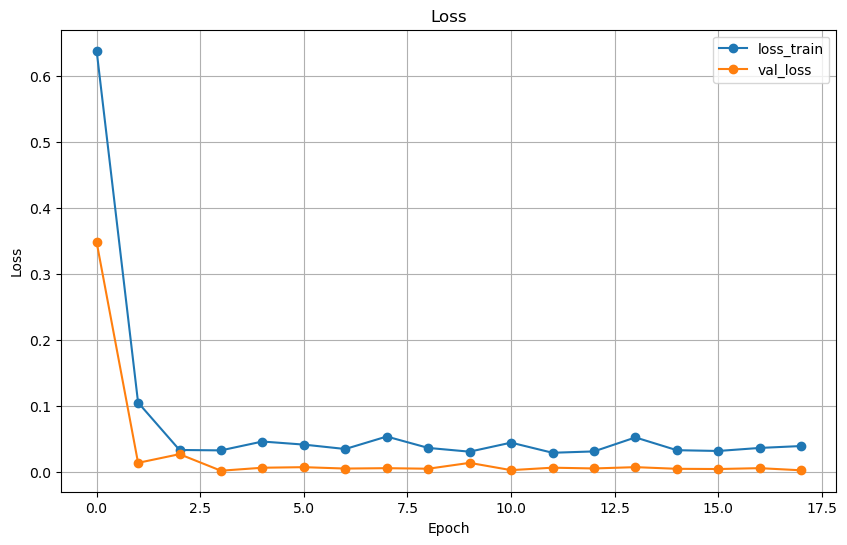

<Figure size 640x480 with 0 Axes>

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(info_epoch['epoch'], info_epoch['train_loss'], label='loss_train', marker='o')
plt.plot(info_epoch['epoch'], info_epoch['val_loss'], label='val_loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('/kaggle/working/loss_vs_epoch.png')


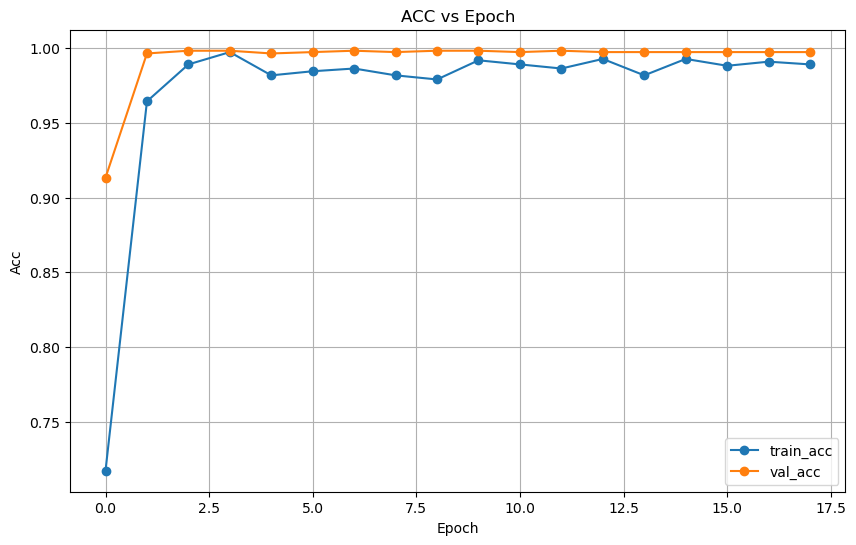

<Figure size 640x480 with 0 Axes>

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(info_epoch['epoch'], info_epoch['train_acc'], label='train_acc', marker='o')
plt.plot(info_epoch['epoch'], info_epoch['val_acc'], label='val_acc', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('ACC vs Epoch')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('/kaggle/working/accuracy_vs_epoch.png')


In [32]:
info_epoch.sort_values(by='f1-val', ascending=False)

,epoch,train_loss,train_acc,f1-train,val_acc,val_loss,f1-val
2,2.0,0.033806,0.989021,0.989024,0.998174,0.027447,0.998174
9,9.0,0.031225,0.991766,0.991766,0.998174,0.014284,0.998173
8,8.0,0.036926,0.978957,0.978957,0.998174,0.005408,0.998173
3,3.0,0.033187,0.997255,0.997255,0.998174,0.002382,0.998173
11,11.0,0.029579,0.986276,0.986277,0.998174,0.006972,0.998173
6,6.0,0.035253,0.986276,0.986277,0.998174,0.005660,0.998173
12,12.0,0.031615,0.992681,0.992682,0.997260,0.005812,0.997260
17,17.0,0.039769,0.989021,0.989021,0.997260,0.003023,0.997260
7,7.0,0.054176,0.981702,0.981702,0.997260,0.006241,0.997260
10,10.0,0.044924,0.989021,0.989021,0.997260,0.003270,0.997260


In [33]:
config = Parameter_model()

weight_best = info_epoch.sort_values(by='f1-val', ascending=False).iloc[0]

 
print(f"Best epoch {weight_best.epoch}")
print(weight_best)
# os.rename(weight_best.path, f'/kaggle/working/weight_best.pth')

Best epoch 2.0
epoch         2.000000
train_loss    0.033806
train_acc     0.989021
f1-train      0.989024
val_acc       0.998174
val_loss      0.027447
f1-val        0.998174
Name: 2, dtype: float64


In [34]:
checkpoint = torch.load(f"/kaggle/working/{config.model}_{int(weight_best.epoch)}.pth")
# checkpoint = torch.load('/kaggle/working/vit_base_patch32_224.augreg_in21k_ft_in1k_18.pth')


In [35]:
best_model_state_dict = checkpoint['model_state_dict']
if config.gem: 
    model = create_model_gem(config)
else:
     model = timm.create_model(
            config.model,
            pretrained=config.pretrained,
#             in_chans=config.in_chans,
            num_classes=config.num_classes,
#             drop_rate=config.drop,
#             drop_path_rate=config.drop_path,
#             global_pool=config.gp
        )

model.load_state_dict(best_model_state_dict)
model.to(device=device)
x = 1

  0%|          | 0/18 [00:00<?, ?it/s]

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 score: 1.00
AUC normal: 1.00
AUC benign: 1.00


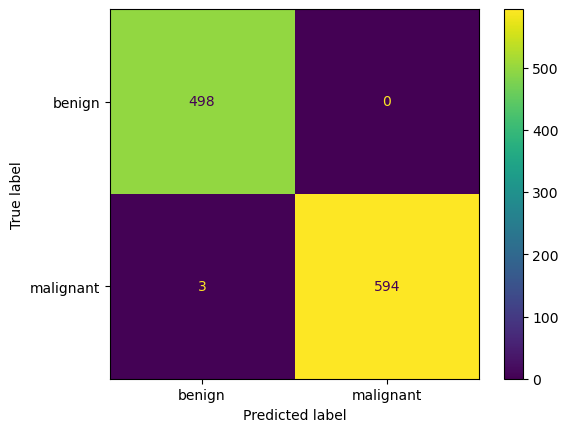

In [36]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score
with torch.no_grad():
    names = []
    y_true = []
    y_pred = []
    for (inputs, labels,name) in tqdm(val_loader):
#         names.append(name)
#         print(list(name))
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        model.to(device)
        outputs = model(inputs)
        predicted = torch.max(outputs,dim=1)[1]

        y_true += labels.tolist()
        y_pred += predicted.tolist()
        names += list(name)
# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=3)
# auc_score = auc(fpr, tpr)

num_labels  =2
y_true_one_hot = np.eye(num_labels)[y_true]
y_pred_one_hot = np.eye(num_labels)[y_pred]
auc_scores = []
for label in range(num_labels):
    auc = roc_auc_score(y_true_one_hot[:, label], y_pred_one_hot[:, label])
    auc_scores.append(auc)

# print("AUC scores for each label:", auc_scores)



# print(f"Result {name_model}")
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 score: {f1:.2f}')
print(f'AUC normal: {auc_scores[0]:.2f}')
print(f'AUC benign: {auc_scores[1]:.2f}')
# print(f'AUC malignant: {auc_scores[2]:.2f}')

cm = confusion_matrix(y_true, y_pred)
cr = classification_report(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['benign','malignant'])
disp.plot()
plt.savefig('confusion_matrix_DDSM.png')
plt.show()